# COSC2753 - Assignment 2 - Classify Images of Colon Cancer

**RMIT University Vietnam**

**Course:** COSC2753

**Group:** MK Sapiens

**Student 1:** Pham Cong Minh - s3818102

**Student 2:** Nguyen Bao Khang - s3817970

**Lecturer:** Dr. Duy Dang Pham Thien

**Submission Due Date:** 21 May 2021

## Main task
* Classify images according to whether given cell image represents a cancerous cells or not (isCancerous).
* Classify images according to cell-type, such as: fibroblast, inflammatory, epithelial or others.

## 1. Setup notebook

In [ ]:
# !pip install tensorflow
# !pip install keras
# !pip install opencv-python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/ColabNotebooks/COSC2753/patch_images.zip"

## 2. Data inspecting

### 2.1. Load csv files

In [ ]:
%cd "/content/drive/MyDrive/ColabNotebooks/COSC2753/"

main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

/content/drive/MyDrive/ColabNotebooks/COSC2753


In [ ]:
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [ ]:
main_data.shape

(9896, 6)

In [ ]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [ ]:
extra_data.shape

(10384, 4)

### 2.2. Inspect csv files

From the specifications, the main_data contains both cellType (0 to 3) and isCancerous (0 and 1), while extra_data only contains isCancerous.

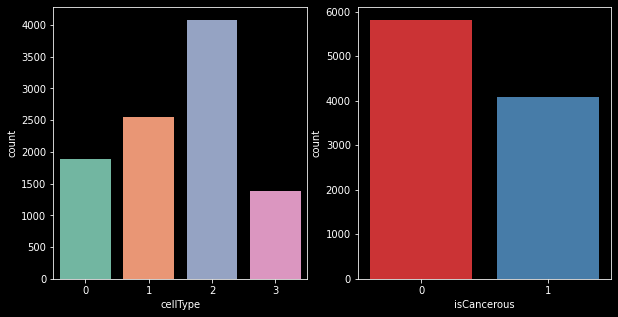

In [ ]:
plt.style.use('dark_background')

# Countplot the cellType and isCancerous
fig, ax =plt.subplots(1,2, figsize = (10,5))

# 0 = fibroblast, 1 = imflammatory, 2 = epithelial, 3 = others
sns.countplot(main_data['cellType'], palette='Set2', ax=ax[0])

sns.countplot(main_data['isCancerous'], palette='Set1', ax=ax[1])
fig.show()

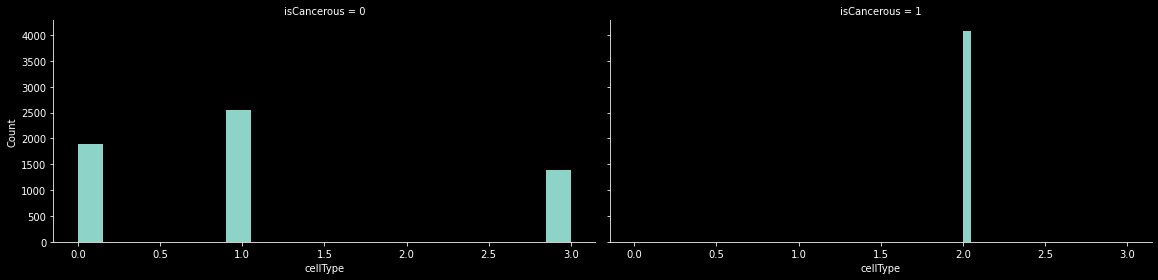

In [ ]:
# Draw the histogram for cellType respected to isCancerous (class 0 and 1)
c = 'cellType'
g = sns.FacetGrid(main_data, col='isCancerous', height=4, aspect=2)
g.map(plt.hist, str(c), bins=20)
g.set_axis_labels(c, "Count")

In [ ]:
# Apply loc to make sure
main_data.loc[(main_data['cellType'] != 2) & (main_data['isCancerous'] == 1)]

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous


From the dataset, it can be said that only cellType = 2 (epithelial) leads to cancerous 

### 2.3. Inspect images

In [ ]:
# Prepare some image of each class
cell0 = main_data['ImageName'].loc[main_data['cellType'] == 0][:4].tolist()
cell1 = main_data['ImageName'].loc[main_data['cellType'] == 1][:4].tolist()
cell2 = main_data['ImageName'].loc[main_data['cellType'] == 2][:4].tolist()
cell3 = main_data['ImageName'].loc[main_data['cellType'] == 3][:4].tolist()

print(cell0)
print(cell1)
print(cell2)
print(cell3)

['22405.png', '22406.png', '22407.png', '22408.png']
['22417.png', '22418.png', '22419.png', '22420.png']
['276.png', '277.png', '278.png', '279.png']
['22423.png', '22424.png', '19061.png', '19062.png']


In [ ]:
# CHANGE THE DIRECTORY IN YOUR LOCAL MACHINE
PATH = "/content/patch_images"

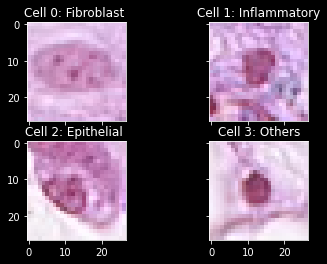

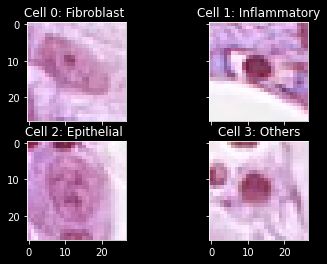

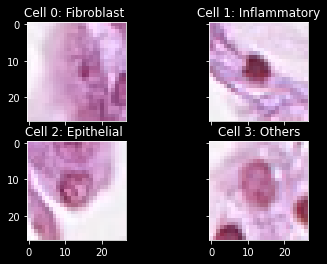

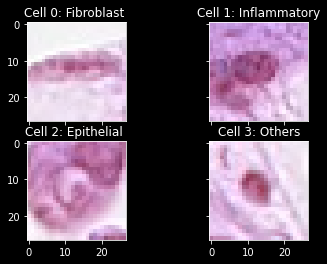

In [ ]:
# Plotting 4 cellType
for i in range (4):
    # Read image
    cell_0 = cv2.imread(os.path.join(PATH, cell0[i]))
    cell_1 = cv2.imread(os.path.join(PATH, cell1[i]))
    cell_2 = cv2.imread(os.path.join(PATH, cell2[i]))
    cell_3 = cv2.imread(os.path.join(PATH, cell3[i]))

    # Create subplots
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
    
    # Draw cellType 0
    ax0.title.set_text("Cell 0: Fibroblast ")
    ax0.imshow(cell_0)
    
    # Draw cellType 1
    ax1.title.set_text("Cell 1: Inflammatory")
    ax1.imshow(cell_1)
    
    # Draw cellType 2
    ax2.title.set_text("Cell 2: Epithelial ")
    ax2.imshow(cell_2)
    
    # Draw cellType 3
    ax3.title.set_text("Cell 3: Others")
    ax3.imshow(cell_3)

    for ax in fig.get_axes():
        ax.label_outer()

## 3. Data preparation

### 3.1. Split data into train and validation (test) set

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into raw train and validation set
# Task 1: Predict isCancerous
raw_train_task1, val_task1 = train_test_split(main_data[['ImageName', 'isCancerous']], 
                                              test_size=0.3, 
                                              random_state=99)

# Task 2: Predict cellType
raw_train_task2, val_task2 = train_test_split(main_data[['ImageName','cellType']], 
                                              test_size=0.3, 
                                              random_state=99)                                        

print('Train shape:', raw_train_task2.shape, 'Validation shape:', val_task2.shape)

Train shape: (6927, 2) Validation shape: (2969, 2)


In [ ]:
raw_train_task1 = raw_train_task1.sort_values(by=['isCancerous']).reset_index(drop = True)
train_X1 = raw_train_task1['ImageName']
train_Y1 = raw_train_task1['isCancerous']

test_X1 = val_task1['ImageName']
test_Y1 = val_task1['isCancerous']

In [ ]:
raw_train_task2 = raw_train_task2.sort_values(by=['cellType']).reset_index(drop = True)
train_X2 = raw_train_task2['ImageName']
train_Y2 = raw_train_task2['cellType']

test_X2 = val_task2['ImageName']
test_Y2 = val_task2['cellType']

### 3.2. Create sample image to balance among classes

In [ ]:
train_Y1.value_counts()

0    4067
1    2860
Name: isCancerous, dtype: int64

In [ ]:
train_Y2.value_counts()

2    2860
1    1780
0    1313
3     974
Name: cellType, dtype: int64

In [ ]:
from random import randint, choice

item_order1 = train_Y1.value_counts().index.tolist()
freq_order1 = train_Y1.value_counts().tolist()

count_list1 = [element for _, element in sorted(zip(item_order1, freq_order1))]# List of value_counts in isCancerous

sum_range1 = count_list1.copy()
for i in range(1, len(sum_range1)):
    sum_range1[i] += sum_range1[i - 1]

sum_range1.insert(0, 0)

MAX1 = max(count_list1)

INTERPOLATION = [cv2.INTER_AREA, cv2.INTER_CUBIC, cv2.INTER_LINEAR, cv2.INTER_NEAREST]

def create_train_isCancerous(directory, img_list):
    train_data = []

    # Add original data 
    for name in tqdm(img_list, desc="Adding original images"):
        img_path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(img_path), (27, 27))
        train_data.append(np.array(img))

    # Add sample data
    for i in tqdm(range(MAX1 - count_list1[1]), desc="Sampling class 1"):
      img_path = os.path.join(directory, choice(img_list[sum_range1[1]:]))
      img = cv2.resize(cv2.imread(img_path), (27, 27), interpolation=INTERPOLATION[randint(0, 3)])
      train_data.append(np.array(img))

    print("\nSuccessfully sample images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [ ]:
item_order2 = train_Y2.value_counts().index.tolist()
freq_order2 = train_Y2.value_counts().tolist()

count_list2 = [element for _, element in sorted(zip(item_order2, freq_order2))]# List of value_counts in cellType

sum_range2 = count_list2.copy()
for i in range(1, len(sum_range2)):
    sum_range2[i] += sum_range2[i - 1]

sum_range2.insert(0, 0)

MAX2 = max(count_list2)

def create_train_cellType(directory, img_list):
    train_data = []

    # Add original data 
    for name in tqdm(img_list, desc="Adding original images"):
        img_path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(img_path), (27, 27))
        train_data.append(np.array(img))

    for i in range(4):
        if i != 2:
            for j in tqdm(range(MAX2 - count_list2[i]), desc="Sampling class ".format(fc=i)):
                img_path = os.path.join(directory, choice(img_list[sum_range2[i]:sum_range2[i + 1]]))
                img = cv2.resize(cv2.imread(img_path), (27, 27), interpolation=INTERPOLATION[randint(0, 3)])
                train_data.append(np.array(img))

    print("\nSuccessfully sample images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [ ]:
def create_test_data(directory, img_list):
    test_data = []
    for name in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(path), (27, 27))
        test_data.append(np.array(img))
    print("\nSuccessfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(test_data).astype('float32') / 255.0 

### 3.3. Create image array

In [ ]:
train_img_X1 = create_train_isCancerous(PATH,train_X1.to_list())
train_img_X1.shape

Sampling class 1: 100%|██████████| 1207/1207 [00:00<00:00, 13454.29it/s]


Successfully sample images!


(8134, 27, 27, 3)

In [ ]:
train_img_X2 = create_train_cellType(PATH, train_X2.to_list())
train_img_X2.shape

Sampling class : 100%|██████████| 1886/1886 [00:00<00:00, 15273.36it/s]


Successfully sample images!


(11440, 27, 27, 3)

In [ ]:
test_img_X1 = create_test_data(PATH, test_X1.to_list())
test_img_X2 = create_test_data(PATH, test_X2.to_list())

test_img_X2.shape

Extracting Image Progress:  38%|███▊      | 1135/2969 [00:00<00:00, 11348.41it/s]


Successfully import images!


Extracting Image Progress: 100%|██████████| 2969/2969 [00:00<00:00, 14138.49it/s]


Successfully import images!


(2969, 27, 27, 3)

In [ ]:
train_mod_Y1 = train_Y1.values
for i in range(2):
  train_mod_Y1 = np.concatenate((train_mod_Y1, np.full((MAX1 - count_list1[i],), i, dtype=int)))

train_mod_Y1.shape

(8134,)

In [ ]:
train_mod_Y2 = train_Y2.values
for i in range(4):
  train_mod_Y2 = np.concatenate((train_mod_Y2, np.full((MAX2 - count_list2[i],), i, dtype=int)))

train_mod_Y2.shape

(11440,)

In [ ]:
test_Y2.shape

(2969,)

In [ ]:
# Create datagen
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

# train_datagen1 = datagen.flow(train_img_X1, train_mod_Y1, batch_size=16, shuffle=True)
train_datagen2 = datagen.flow(train_img_X2, train_mod_Y2, batch_size=16, shuffle=True)

## 4. Constructing CNN network

### 4.1. Model for task 1: isCancerous

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

model_isCancerous = Sequential()  # Initiate the model

# First convolutional layer(s)
model_isCancerous.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.2))

# Second convolutional layer(s)
model_isCancerous.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.3))

# Third convolutional layer(s)
model_isCancerous.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.4))

# Fully connected layer(s)
model_isCancerous.add(Flatten())
model_isCancerous.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Dropout(0.2))
model_isCancerous.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Dropout(0.2))
model_isCancerous.add(Dense(2, activation='softmax')) # Output is 0 and 1

model_isCancerous.summary()

### 4.2. Constructing CNN network for cellType

In [ ]:
model_cellType = Sequential()  # Initiate the model

# First convolutional layer(s)
model_cellType.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model_cellType.add(BatchNormalization())
model_cellType.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_cellType.add(BatchNormalization())
model_cellType.add(MaxPooling2D((2, 2)))
model_cellType.add(Dropout(0.2))

# Second convolutional layer(s)
model_cellType.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_cellType.add(BatchNormalization())
model_cellType.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_cellType.add(BatchNormalization())
model_cellType.add(MaxPooling2D((2, 2)))
model_cellType.add(Dropout(0.3))

# Third convolutional layer(s)
model_cellType.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_cellType.add(BatchNormalization())
model_cellType.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_cellType.add(BatchNormalization())
model_cellType.add(MaxPooling2D((2, 2)))
model_cellType.add(Dropout(0.4))

# Fully connected layer(s)
model_cellType.add(Flatten())
model_cellType.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model_cellType.add(BatchNormalization())
model_cellType.add(Dropout(0.2))
model_cellType.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model_cellType.add(BatchNormalization())
model_cellType.add(Dropout(0.2))
model_cellType.add(Dense(4, activation='softmax')) # Output is 0 to 3

model_cellType.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        1

## 5. Compile and training

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.0005, beta_1=0.4, beta_2=0.444, decay=1.0e-6, amsgrad=True)

model_isCancerous.compile(optimizer=opt , loss='binary_crossentropy', metrics=['accuracy'])
model_cellType.compile(optimizer=opt , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15) 

EPOCHS = 500
BATCH_SIZE = 32


In [ ]:
import time
start_time = time.time()
history_1 = model_isCancerous.fit(train_datagen1, 
                                  validation_data=(test_img_X1, test_Y1), 
                                  batch_size=BATCH_SIZE, 
                                  epochs=EPOCHS, 
                                  verbose=1,
                                  callbacks=[reduce_lr, early])

print("---  Training cellType model in seconds ---%s " % (time.time() - start_time))

In [ ]:
start_time = time.time()
history_2 = model_cellType.fit(train_datagen2, 
                               validation_data=(test_img_X2, test_Y2), 
                               batch_size=BATCH_SIZE, 
                               epochs=EPOCHS, 
                               verbose=1,
                               callbacks=[reduce_lr, early])

print("---  Training cellType model in seconds ---%s " % (time.time() - start_time))

Epoch 1/500
715/715 [==============================] - 10s 8ms/step - loss: 20.3592 - accuracy: 0.4617 - val_loss: 17.8017 - val_accuracy: 0.6807
Epoch 2/500
715/715 [==============================] - 5s 7ms/step - loss: 17.4836 - accuracy: 0.5867 - val_loss: 15.9017 - val_accuracy: 0.6713
Epoch 3/500
715/715 [==============================] - 5s 7ms/step - loss: 15.5365 - accuracy: 0.6052 - val_loss: 14.1551 - val_accuracy: 0.7097
Epoch 4/500
715/715 [==============================] - 5s 7ms/step - loss: 13.9393 - accuracy: 0.6321 - val_loss: 12.7939 - val_accuracy: 0.7039
Epoch 5/500
715/715 [==============================] - 5s 7ms/step - loss: 12.6086 - accuracy: 0.6438 - val_loss: 11.6323 - val_accuracy: 0.7033
Epoch 6/500
715/715 [==============================] - 5s 7ms/step - loss: 11.4606 - accuracy: 0.6527 - val_loss: 10.6153 - val_accuracy: 0.7326
Epoch 7/500
715/715 [==============================] - 5s 7ms/step - loss: 10.4973 - accuracy: 0.6724 - val_loss: 9.7427 - val_ac

In [ ]:
from datetime import datetime
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
export1 = 'BEST_ISCANCEROUS_({ft}).h5'.format(ft=dt_string)
export2 = 'BEST_CELLTYPE_({ft}).h5'.format(ft=dt_string)

print(export1)
print(export2)

model_isCancerous.save(export1)
model_cellType.save(export2)

BEST_MIDNIGHT_(20/05/2021 18:46:09).h5


93/93 [==============================] - 0s 4ms/step - loss: 1.2608 - accuracy: 0.8100
Validation loss: 1.260782241821289
Validation accuracy: 0.8100370764732361
Max Validation accuracy: 0.9922202825546265


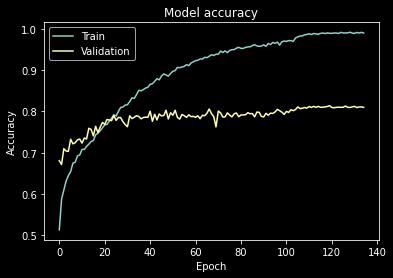

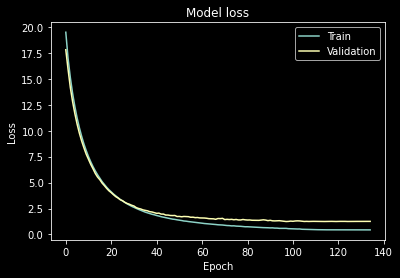

In [ ]:
scores_isCancerous = model_isCancerous.evaluate(test_img_X2, test_Y2, verbose=1)
print('Validation loss:', scores_isCancerous[0])
print('Validation accuracy:', scores_isCancerous[1])
print('Max Validation accuracy:', max(history1.history['accuracy']))

# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
scores_cellType = model_cellType.evaluate(test_img_X2, test_Y2, verbose=1)
print('Validation loss:', scores_cellType[0])
print('Validation accuracy:', scores_cellType[1])
print('Max Validation accuracy:', max(history2.history['accuracy']))

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()